Sayısal sütunlar: Index(['temp', 'feelslike', 'dew', 'humidity', 'precip', 'windspeedmean',
       'sealevelpressure', 'cloudcover', 'BarajDoluluk', 'dakika'],
      dtype='object')


<ipython-input-6-6e889e60aab6>:173: RuntimeWarning: divide by zero encountered in divide
  test_mape = np.mean(np.abs((np.array(test_actuals) - np.array(test_preds)) / np.array(test_actuals))) * 100


Epoch 1/5, Train Loss: 0.20191879354176984, Test Loss: 0.11577148953288355
Train MSE: 0.20265433630686763, Test MSE: 0.1184940525883752
Train MAPE: 152.05992460250854%, Test MAPE: inf%
Train MAE: 0.3558846469830024, Test MAE: 0.31527264661173215
Train RMSE: 0.45017145212337445, Test RMSE: 0.3442296509430517
Train R²: -0.9925807167464451, Test R²: 0.00371317804609006
Training Time: 52.56494855880737 seconds, Inference Time: 6.581072568893433 seconds


<ipython-input-6-6e889e60aab6>:173: RuntimeWarning: divide by zero encountered in divide
  test_mape = np.mean(np.abs((np.array(test_actuals) - np.array(test_preds)) / np.array(test_actuals))) * 100


Epoch 2/5, Train Loss: 0.1610126966430295, Test Loss: 0.03910173133001937
Train MSE: 0.1611584291678537, Test MSE: 0.036941750416350595
Train MAPE: 89.01687264442444%, Test MAPE: inf%
Train MAE: 0.2757320740323783, Test MAE: 0.1492402958876963
Train RMSE: 0.401445424893414, Test RMSE: 0.19220236839422816
Train R²: -0.5845759047304966, Test R²: 0.6893972455514517
Training Time: 50.94323801994324 seconds, Inference Time: 6.559967756271362 seconds


<ipython-input-6-6e889e60aab6>:173: RuntimeWarning: divide by zero encountered in divide
  test_mape = np.mean(np.abs((np.array(test_actuals) - np.array(test_preds)) / np.array(test_actuals))) * 100


Epoch 3/5, Train Loss: 0.13548878464166836, Test Loss: 0.0460242835132008
Train MSE: 0.13590213514237978, Test MSE: 0.043711405049451
Train MAPE: 45.93276381492615%, Test MAPE: inf%
Train MAE: 0.21057215337140928, Test MAE: 0.16154436375242923
Train RMSE: 0.3686490677356716, Test RMSE: 0.2090727266992302
Train R²: -0.3362456426262934, Test R²: 0.632478627673082
Training Time: 51.88664698600769 seconds, Inference Time: 5.566504001617432 seconds


<ipython-input-6-6e889e60aab6>:173: RuntimeWarning: divide by zero encountered in divide
  test_mape = np.mean(np.abs((np.array(test_actuals) - np.array(test_preds)) / np.array(test_actuals))) * 100


Epoch 4/5, Train Loss: 0.11954596428380858, Test Loss: 0.04180386848442782
Train MSE: 0.11931933670426574, Test MSE: 0.03895856353596579
Train MAPE: 43.190449476242065%, Test MAPE: inf%
Train MAE: 0.1909263669125902, Test MAE: 0.15553100892465632
Train RMSE: 0.3454263115401977, Test RMSE: 0.19737923785435435
Train R²: -0.173196753568994, Test R²: 0.672440070996908
Training Time: 51.68877410888672 seconds, Inference Time: 5.4550769329071045 seconds


<ipython-input-6-6e889e60aab6>:173: RuntimeWarning: divide by zero encountered in divide
  test_mape = np.mean(np.abs((np.array(test_actuals) - np.array(test_preds)) / np.array(test_actuals))) * 100


Epoch 5/5, Train Loss: 0.12446956312464129, Test Loss: 0.03924046960609678
Train MSE: 0.1247835358847584, Test MSE: 0.03521726777702808
Train MAPE: 38.47762644290924%, Test MAPE: inf%
Train MAE: 0.18866852537726958, Test MAE: 0.14410776340947398
Train RMSE: 0.35324713146005643, Test RMSE: 0.18766264353095977
Train R²: -0.22692300546140154, Test R²: 0.7038965329900677
Training Time: 51.42587375640869 seconds, Inference Time: 5.430147171020508 seconds


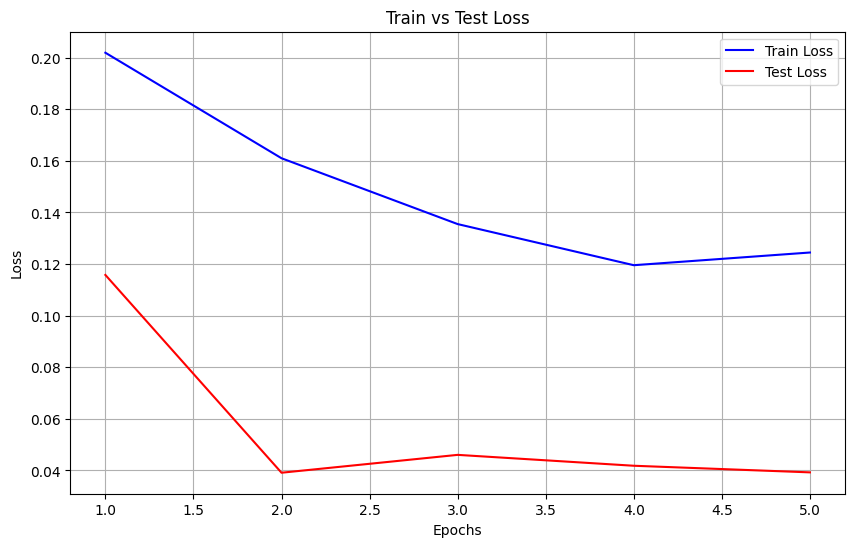

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torch.optim import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import time  # Eğitim ve çıkarım sürelerini takip etmek için ekledim

# Küçük bir sabit ekleyerek sıfır bölme hatasını engelleme
epsilon = 1e-6  # Küçük bir sabit

# Veriyi yükleme
file_path = "kazanderekullan.xlsx"  # Excel dosyasının yolunu girin
data = pd.read_excel(file_path)

# Tarih sütununu datetime formatına çevirme
data['datetime'] = pd.to_datetime(data['datetime'])
data.set_index('datetime', inplace=True)

# Sadece sayısal sütunları seçme
numeric_columns = data.select_dtypes(include=["float64", "int64"]).columns
print("Sayısal sütunlar:", numeric_columns)

# Normalizasyon (0-1 aralığına getirme)
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data[numeric_columns])

# Ölçeklenmiş veriyi DataFrame formatına geri dönüştürme
scaled_data = pd.DataFrame(scaled_data, columns=numeric_columns, index=data.index)

# Veriyi eğitim ve test olarak ayırma
train_size = int(len(scaled_data) * 0.7)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

# Pencereleme (windowing) fonksiyonu
def create_sequences(data, target_index, seq_length=30):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length, :])
        y.append(data[i+seq_length, target_index])
    return np.array(X), np.array(y)

# Modelin tahmin edeceği hedef sütun
if "BarajDoluluk" in scaled_data.columns:
    target_index = list(scaled_data.columns).index("BarajDoluluk")
else:
    raise ValueError("Hedef sütun 'BarajDoluluk' veri kümesinde bulunamadı!")

seq_length = 365

# Pencereleme
X_train, y_train = create_sequences(train_data.values, target_index, seq_length)
X_test, y_test = create_sequences(test_data.values, target_index, seq_length)

# Torch veri seti ve veri yükleyiciler
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return self.X[index], self.y[index]

# Dataset ve DataLoader
train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Temporal Fusion Transformer (TFT) Modeli
class TemporalFusionTransformer(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(TemporalFusionTransformer, self).__init__()
        # LSTM katmanı (geleneksel zaman serisi öğrenme)
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)

        # TFT'nin temel bileşenlerinden olan konvasyonel katmanlar
        self.attn_layer = nn.MultiheadAttention(embed_dim=hidden_dim, num_heads=4, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

        # Diğer TFT katmanları (eklenebilir)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        # LSTM katmanı çıkışı
        lstm_out, _ = self.lstm(x)

        # Multihead Attention katmanı (geleneksel zaman serisi için)
        attn_out, _ = self.attn_layer(lstm_out, lstm_out, lstm_out)

        # TFT modelindeki tam bağlı katman
        output = self.fc(attn_out[:, -1, :])  # Sadece son zaman dilimindeki tahmin
        output = self.dropout(output)
        return output

# Model parametreleri
input_dim = len(numeric_columns)  # Özellik sayısı
hidden_dim = 64  # LSTM katmanının gizli boyutu
output_dim = 1  # Baraj doluluk yüzdesi

# Modeli oluşturma
model = TemporalFusionTransformer(input_dim, hidden_dim, output_dim)
criterion = nn.MSELoss()  # Kayıp fonksiyonu (Mean Squared Error)
optimizer = Adam(model.parameters(), lr=0.001)

# Model eğitimi
epochs = 5  # Eğitim süresini artırdım
train_losses = []
test_losses = []

# Eğitim ve çıkarım sürelerini kaydetmek için listeler
train_times = []
inference_times = []

for epoch in range(epochs):
    model.train()
    train_loss = 0
    train_preds = []
    train_actuals = []

    start_train = time.time()  # Eğitim zamanı başlat
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        predictions = model(X_batch).squeeze()
        loss = criterion(predictions, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        train_preds.extend(predictions.cpu().detach().numpy())
        train_actuals.extend(y_batch.cpu().detach().numpy())
    end_train = time.time()  # Eğitim zamanı bitir
    train_times.append(end_train - start_train)  # Eğitim süresini kaydet

    train_losses.append(train_loss / len(train_loader))

    # Eğitim metriklerini hesapla
    train_mse = mean_squared_error(train_actuals, train_preds)
    train_mape = np.mean(np.abs((np.array(train_actuals) - np.array(train_preds)) / np.array(train_actuals))) * 100
    train_mae = mean_absolute_error(train_actuals, train_preds)
    train_rmse = np.sqrt(train_mse)
    train_r2 = r2_score(train_actuals, train_preds)

    # Test değerlendirme
    model.eval()
    test_loss = 0
    test_preds = []
    test_actuals = []

    start_inference = time.time()  # Çıkarım zamanı başlat
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            predictions = model(X_batch).squeeze()
            loss = criterion(predictions, y_batch)
            test_loss += loss.item()

            test_preds.extend(predictions.cpu().detach().numpy())
            test_actuals.extend(y_batch.cpu().detach().numpy())
    end_inference = time.time()  # Çıkarım zamanı bitir
    inference_times.append(end_inference - start_inference)  # Çıkarım süresini kaydet

    test_losses.append(test_loss / len(test_loader))

    test_mse = mean_squared_error(test_actuals, test_preds)
    test_mape = np.mean(np.abs((np.array(test_actuals) - np.array(test_preds)) / np.array(test_actuals))) * 100
    test_mae = mean_absolute_error(test_actuals, test_preds)
    test_rmse = np.sqrt(test_mse)
    test_r2 = r2_score(test_actuals, test_preds)

    # Sonuçları yazdırma
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]}, Test Loss: {test_losses[-1]}")
    print(f"Train MSE: {train_mse}, Test MSE: {test_mse}")
    print(f"Train MAPE: {train_mape}%, Test MAPE: {test_mape}%")
    print(f"Train MAE: {train_mae}, Test MAE: {test_mae}")
    print(f"Train RMSE: {train_rmse}, Test RMSE: {test_rmse}")
    print(f"Train R²: {train_r2}, Test R²: {test_r2}")
    print(f"Training Time: {train_times[-1]} seconds, Inference Time: {inference_times[-1]} seconds")

# Gerçek ve tahmin edilen değerleri birleştirip Excel dosyasına kaydetme (Eğitim ve çıkarım süreleri hariç)
result_df = pd.DataFrame({
    'Gerçek Değerler': test_actuals,
    'Tahminler': test_preds
})

# Excel dosyasına kaydetme
result_df.to_excel("kazandereveriler.xlsx", index=False)

# Kayıpların grafiğini çizme
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs+1), train_losses, label="Train Loss", color='blue')
plt.plot(range(1, epochs+1), test_losses, label="Test Loss", color='red')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train vs Test Loss")
plt.legend()
plt.grid(True)
plt.show()
